# Présidentielle 2022 - Candidats

Analysons les programmes des candidats à la présidentielle 2022 avec des outils d'analyse du langage naturel (NLP).

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud

from database import load_data

set_matplotlib_formats("svg")

## Données brutes

Chargeons les données brutes à partir de la base de données des programmes collectés.

In [2]:
data = load_data()

INFO:database:Loading data: /Users/romain/Documents/dev/presidentielle-2022-programmes/data.db


In [3]:
data

,index,name,program_url,easy_read_url,program_text,easy_read_text
0,0,Madame Nathalie ARTHAUD,https://www.cnccep.fr/pdfs/Candidat-01-Nathali...,https://www.cnccep.fr/pdfs/Candidat-01-Nathali...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,1,Monsieur Nicolas DUPONT-AIGNAN,https://www.cnccep.fr/pdfs/Candidat-02-Nicolas...,https://www.cnccep.fr/pdfs/Candidat-02-Nicolas...,\n\n un hoMMe ...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
2,2,Madame Anne HIDALGO,https://www.cnccep.fr/pdfs/Candidat-03-Anne-Hi...,https://www.cnccep.fr/pdfs/Candidat-03-Anne-Hi...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n ...
3,3,Monsieur Yannick JADOT,https://www.cnccep.fr/pdfs/Candidat-04-Yannick...,https://www.cnccep.fr/pdfs/Candidat-04-Yannick...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
4,4,Monsieur Jean LASSALLE,https://www.cnccep.fr/pdfs/Candidat-05-Jean-La...,https://www.cnccep.fr/pdfs/Candidat-05-Jean-La...,\n\n L A F R A N C E ...,\n\n\n\n La France authen...
5,5,Madame Marine LE PEN,https://www.cnccep.fr/pdfs/Candidat-06-Marine-...,https://www.cnccep.fr/pdfs/Candidat-06-Marine-...,"\n\n\n\n\n\n\n\n\n\n\n\n Madame, Mon...","\n\n\n\n Madame, Monsieur,\n ..."
6,6,Monsieur Emmanuel MACRON,https://www.cnccep.fr/pdfs/Candidat-07-Emmanue...,https://www.cnccep.fr/pdfs/Candidat-07-Emmanue...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n Ce document a é...
7,7,Monsieur Jean-Luc MELENCHON,https://www.cnccep.fr/pdfs/Candidat-08-Jean-Lu...,https://www.cnccep.fr/pdfs/Candidat-08-Jean-Lu...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
8,8,Madame Valerie PECRESSE,https://www.cnccep.fr/pdfs/Candidat-09-Valerie...,https://www.cnccep.fr/pdfs/Candidat-09-Valerie...,\n\n ÉLECTION PRÉSIDE...,\n\n ÉLECTION PRÉSIDENTIELLE / LE DIMAN...
9,9,Monsieur Philippe POUTOU,https://www.cnccep.fr/pdfs/Candidat-10-Philipp...,https://www.cnccep.fr/pdfs/Candidat-10-Philipp...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n ...


## Vectorisation

Transformons les programmes en vecteurs de mots avec la méthode TF-IDF.

In [4]:
names = data["name"]

name_tokens = list(set(re.split(" |-", " ".join(names).lower())))
stop_words = [
    "000", "001", "044", "063", "093", "00139", "00296voi",
    "la", "le", "les", "ce", "ma",
    "je", "il", "elle", "nous", "vous", "ils", "elles",
    "ai", "ont", "est", "etre", "ete", "sera", "serai", "seront", "suis", "sont",
    "nos", "notre", "votre", "sa", "son",
    "de", "du", "des", "et", "en", "un", "une", "ans", "au", "aux", "se", "me", "ne", "ni", "ou",
    "qu", "que", "qui", "rai",
    "pas", "par", "pour", "dans", "dont", "sur", "avec", "contre", "mais", "plus", "jusqu",
    "france", "francais",
    *name_tokens,
]

vectorizer = TfidfVectorizer(strip_accents="unicode", lowercase=True, stop_words=stop_words)
vec_program = vectorizer.fit_transform(data["program_text"])
vec_feature_names = vectorizer.get_feature_names_out()

pd.DataFrame(vec_feature_names)

,0
0,01
1,02
2,03
3,04
4,05
...,...
3546,zones
3547,œuvrant
3548,œuvre
3549,œuvrer


## Nuage de mots

Peut-on obtenir une vue globale des programmes de chaque candidat avec un nuage de mots ?

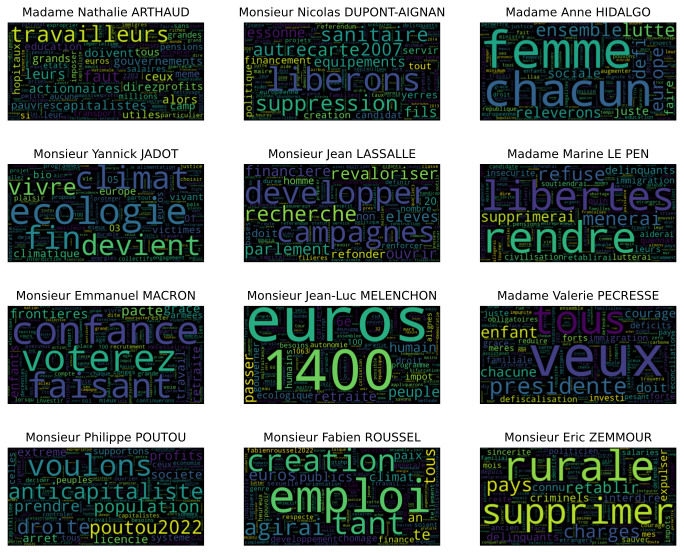

In [5]:
freqs = pd.DataFrame(vec_program.toarray(), columns=vec_feature_names)

fig = plt.figure(figsize=(12, 10), dpi=144)
for i in range(len(data.index)):
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(freqs.iloc[i])
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(wordcloud)
    plt.title(data.iloc[i]["name"])
    plt.axis("off")

## Fréquence de termes

Quelles sont les termes prépondérants de cette campagne ?

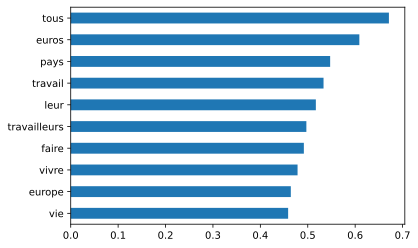

In [6]:
_ = freqs.sum(axis=0).nlargest(10).sort_values(ascending=True).plot.barh()

## Plus proches voisins

Quels sont les plus proches voisins de chaque candidat ?

In [7]:
neighbors = NearestNeighbors(n_neighbors=4).fit(vec_program.toarray())
distances, indices = neighbors.kneighbors(vec_program.toarray())

names = data["name"]
nearest_neighbors = np.array(
    [
        [names[ind[0]], names[ind[1]], names[ind[2]], names[ind[3]]]
        for ind in indices
    ]
)

pd.DataFrame(nearest_neighbors, columns=["Candidat", "Voisin 1", "Voisin 2", "Voisin 3"])

,Candidat,Voisin 1,Voisin 2,Voisin 3
0,Madame Nathalie ARTHAUD,Monsieur Philippe POUTOU,Monsieur Fabien ROUSSEL,Madame Anne HIDALGO
1,Monsieur Nicolas DUPONT-AIGNAN,Monsieur Eric ZEMMOUR,Madame Valerie PECRESSE,Madame Anne HIDALGO
2,Madame Anne HIDALGO,Monsieur Fabien ROUSSEL,Monsieur Jean-Luc MELENCHON,Monsieur Yannick JADOT
3,Monsieur Yannick JADOT,Monsieur Fabien ROUSSEL,Madame Anne HIDALGO,Madame Valerie PECRESSE
4,Monsieur Jean LASSALLE,Madame Anne HIDALGO,Madame Valerie PECRESSE,Monsieur Fabien ROUSSEL
5,Madame Marine LE PEN,Monsieur Eric ZEMMOUR,Madame Anne HIDALGO,Madame Valerie PECRESSE
6,Monsieur Emmanuel MACRON,Madame Anne HIDALGO,Madame Valerie PECRESSE,Monsieur Fabien ROUSSEL
7,Monsieur Jean-Luc MELENCHON,Madame Anne HIDALGO,Monsieur Fabien ROUSSEL,Monsieur Philippe POUTOU
8,Madame Valerie PECRESSE,Madame Anne HIDALGO,Monsieur Eric ZEMMOUR,Monsieur Fabien ROUSSEL
9,Monsieur Philippe POUTOU,Monsieur Fabien ROUSSEL,Madame Nathalie ARTHAUD,Monsieur Jean-Luc MELENCHON


## Corrélations

Peut-ton quantifier les affinités entre chaque couple de candidats ?

In [8]:
df_corr = pd.DataFrame(vec_program.toarray().T, columns=names).corr().abs()
df_corr.style.background_gradient(cmap="viridis").format(precision=2)

name,Madame Nathalie ARTHAUD,Monsieur Nicolas DUPONT-AIGNAN,Madame Anne HIDALGO,Monsieur Yannick JADOT,Monsieur Jean LASSALLE,Madame Marine LE PEN,Monsieur Emmanuel MACRON,Monsieur Jean-Luc MELENCHON,Madame Valerie PECRESSE,Monsieur Philippe POUTOU,Monsieur Fabien ROUSSEL,Monsieur Eric ZEMMOUR
name,,,,,,,,,,,,
Madame Nathalie ARTHAUD,1.00,0.04,0.04,0.01,0.03,0.00,0.01,0.02,0.01,0.09,0.09,0.01
Monsieur Nicolas DUPONT-AIGNAN,0.04,1.00,0.02,0.00,0.01,0.01,0.01,0.01,0.03,0.02,0.03,0.02
Madame Anne HIDALGO,0.04,0.02,1.00,0.12,0.04,0.07,0.09,0.11,0.07,0.05,0.15,0.02
Monsieur Yannick JADOT,0.01,0.00,0.12,1.00,0.01,0.01,0.04,0.07,0.07,0.06,0.15,0.03
Monsieur Jean LASSALLE,0.03,0.01,0.04,0.01,1.00,0.00,0.01,0.01,0.02,0.01,0.03,0.04
Madame Marine LE PEN,0.00,0.01,0.07,0.01,0.00,1.00,0.01,0.03,0.05,0.02,0.04,0.06
Monsieur Emmanuel MACRON,0.01,0.01,0.09,0.04,0.01,0.01,1.00,0.04,0.05,0.01,0.06,0.00
Monsieur Jean-Luc MELENCHON,0.02,0.01,0.11,0.07,0.01,0.03,0.04,1.00,0.01,0.07,0.13,0.00
Madame Valerie PECRESSE,0.01,0.03,0.07,0.07,0.02,0.05,0.05,0.01,1.00,0.02,0.08,0.05


## Extraction de thèmes

Peut-on extraire 5 thèmes prépondérants ? (Utilisation des méthodes NMF et LDA)

In [9]:
nmf = NMF(n_components=5, init="nndsvda").fit(vec_program.toarray())
for i in range(nmf.n_components):
    print(f"Thème {i}:", vec_feature_names[np.argpartition(nmf.components_[i], -5)[-5:]])

Thème 0: ['vivre' 'europe' 'climat' 'ecologie' 'euros']
Thème 1: ['mes' 'veux' 'delinquants' 'pays' 'immigration']
Thème 2: ['ceux' 'capitalistes' 'profits' 'voulons' 'travailleurs']
Thème 3: ['europeenne' '20' 'politique' 'liberons' 'suppression']
Thème 4: ['frontieres' 'voterez' 'confance' 'faisant' 'pacte']


In [10]:
lda = LatentDirichletAllocation(n_components=5).fit(vec_program.toarray())
for i in range(lda.n_components):
    print(f"Thème {i}:", vec_feature_names[np.argpartition(lda.components_[i], -5)[-5:]])

Thème 0: ['vivre' 'ecologie' 'faisant' 'voterez' 'confance']
Thème 1: ['developper' 'si' 'leurs' 'faut' 'travailleurs']
Thème 2: ['face' 'travail' 'tous' 'euros' 'voulons']
Thème 3: ['menerai' 'libertes' 'leur' 'emploi' 'rendre']
Thème 4: ['chacun' 'europeenne' 'femme' 'lutte' 'liberons']


## Cartographie

Est-il possible d'obtenir une cartographie 2D des candidats ? (Réduction de dimension par PCA)

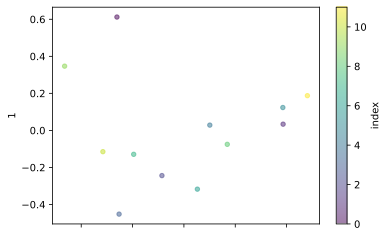

In [11]:
pca = PCA(n_components=2)
pca_program = pca.fit_transform(vec_program.toarray())
df_pca_program = pd.DataFrame(pca_program).reset_index()

colors = list(range(12))
ax = df_pca_program.plot.scatter(x=0, y=1, c="index", cmap="viridis", alpha=0.5, legend=True)